In [1]:
"""
Example evaluation script for a custom (ImageFolder-style) test set
using a pretrained ResNet-34 model.

The script:
1. Extracts a ZIP archive containing the images and a *labels_list.json* file
2. Loads the class-index ↔︎ ImageNet-index mapping from *labels_list.json*
3. Applies the standard ImageNet normalization and wraps the images in a
   `torch.utils.data.DataLoader`
4. Computes *top-1* and *top-5* accuracy on the test set

"""

# ---- imports ----─────────────────────────────────────────────────────────────
import os
import zipfile
import json
from pathlib import Path
from typing import Dict

import numpy as np
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader

# ---- constants & paths ----───────────────────────────────────────────────────
ZIP_FILE_PATH: Path = Path("./TestDataSet.zip")
EXTRACT_DIR: Path  = Path("./TestDataSet")
LABELS_JSON_PATH: Path = EXTRACT_DIR / "labels_list.json"

BATCH_SIZE: int = 32        # images per mini-batch
MEAN_NORMS = np.array([0.485, 0.456, 0.406])   # ImageNet RGB means
STD_NORMS  = np.array([0.229, 0.224, 0.225])   # ImageNet RGB std-devs

# ---- 1. (Un)zip the dataset ----──────────────────────────────────────────────
if not EXTRACT_DIR.is_dir():
    # Fail fast if the ZIP archive is missing
    if not ZIP_FILE_PATH.exists():
        raise FileNotFoundError(f"{ZIP_FILE_PATH} not found.")
    # Extract to the current working directory (creates *EXTRACT_DIR*)
    with zipfile.ZipFile(ZIP_FILE_PATH, "r") as zip_ref:
        zip_ref.extractall(".")
    print(f"Extracted {ZIP_FILE_PATH} → {EXTRACT_DIR}")
else:
    print(f"{EXTRACT_DIR} already exists — skipping extraction")

# ---- 2. Load label mapping ----───────────────────────────────────────────────
if not LABELS_JSON_PATH.exists():
    raise FileNotFoundError(f"{LABELS_JSON_PATH} not found.")

with open(LABELS_JSON_PATH, "r", encoding="utf-8") as fp:
    label_list = json.load(fp)
print("Loaded label mapping (first five entries):", label_list[:5])

# ---- 3. Define preprocessing transforms ----──────────────────────────────────
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN_NORMS.tolist(),
                         std=STD_NORMS.tolist()),
])

# ---- 4. Load the dataset ----─────────────────────────────────────────────────
dataset = datasets.ImageFolder(
    root=str(EXTRACT_DIR),
    transform=preprocess
)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# ---- 5. Build mapping: ImageFolder → ImageNet index ----──────────────────────
imagefolder_to_imagenet: Dict[int, int] = {
    idx: int(label_list[idx].split(":", 1)[0])
    for idx in dataset.class_to_idx.values()
}
print("Class index mapping (sample):",
      list(imagefolder_to_imagenet.items())[:5])

# ---- 6. Load pretrained ResNet-34 ----────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# `weights=` is the recommended API in torchvision ≥ 0.13
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model = model.to(device).eval()   # put model in inference mode

# ---- 7. Evaluate Top-1 and Top-5 accuracy ----───────────────────────────────
total_samples   = 0
top1_correct    = 0
top5_correct    = 0

with torch.no_grad():             # disables gradient tracking → lower memory
    for inputs, labels in dataloader:
        inputs = inputs.to(device)

        # Convert ImageFolder class indices to ImageNet class indices
        imagenet_labels = torch.as_tensor(
            [imagefolder_to_imagenet[label.item()] for label in labels],
            dtype=torch.long, device=device
        )

        outputs = model(inputs)                 # forward pass
        _, top5_preds = outputs.topk(5, dim=1)  # get best-5 predictions

        # Top-1 accuracy (first element of each row in `top5_preds`)
        top1_preds = top5_preds[:, 0]
        top1_correct += (top1_preds == imagenet_labels).sum().item()

        # Top-5 accuracy (does the correct class appear anywhere in the row?)
        top5_correct += (
            (top5_preds == imagenet_labels.unsqueeze(1)).any(dim=1)
        ).sum().item()

        total_samples += labels.size(0)

# Compute metrics as percentages
top1_acc = 100.0 * top1_correct / total_samples
top5_acc = 100.0 * top5_correct / total_samples

print(f"Baseline Top-1 Accuracy: {top1_acc:6.2f}%")
print(f"Baseline Top-5 Accuracy: {top5_acc:6.2f}%")

Extracted ./TestDataSet.zip to ./TestDataSet
Loaded label mapping; first 5 entries: ['401: accordion', '402: acoustic guitar', '403: aircraft carrier', '404: airliner', '405: airship']
Mapping example: [(0, 401), (1, 402), (2, 403), (3, 404), (4, 405)]


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 148MB/s]


Baseline Top-1 Accuracy: 76.00%
Baseline Top-5 Accuracy: 94.20%


FGSM Attack & Save: 100%|██████████| 500/500 [00:11<00:00, 42.46it/s]
<ipython-input-12-9ad6f79a1943>:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Total attack time:      11.78 s
Average time / image:   0.0236 s
Max L∞ perturbation:    0.0200  (≤ 0.02)
Adversarial Top-1 Acc.: 6.00%
Adversarial Top-5 Acc.: 35.40%


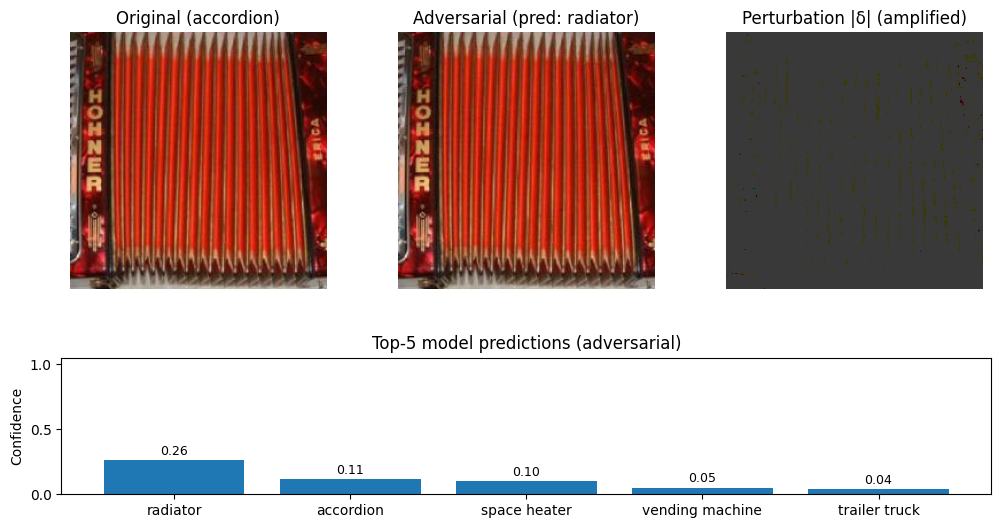

<ipython-input-12-9ad6f79a1943>:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


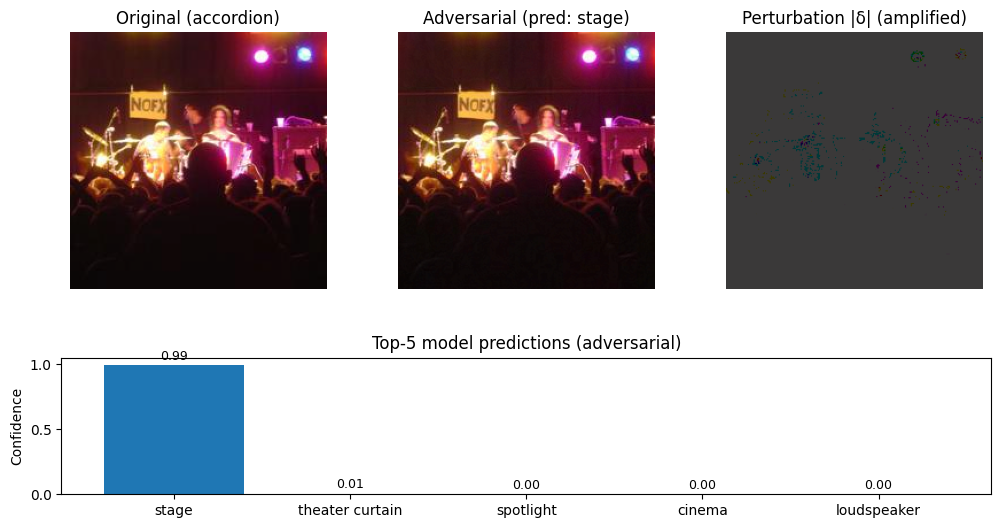

<ipython-input-12-9ad6f79a1943>:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


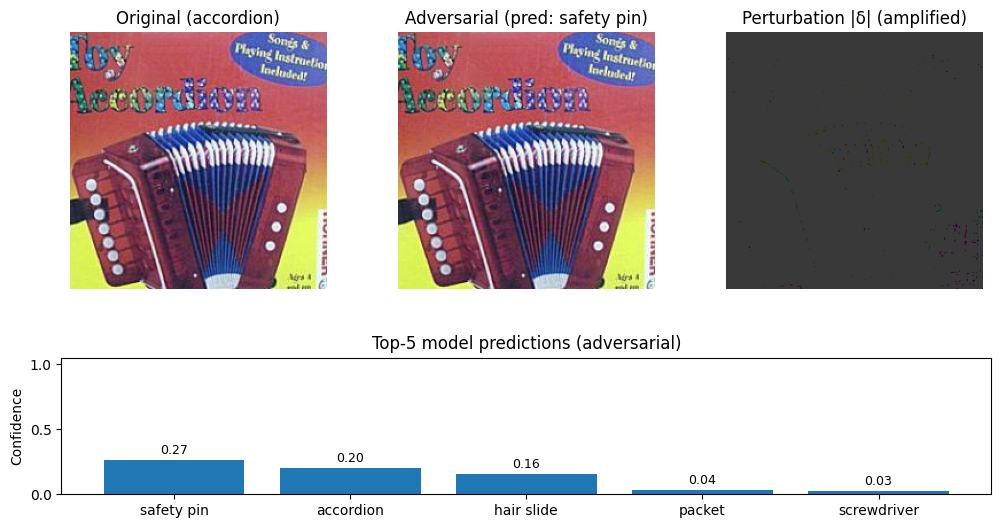

<ipython-input-12-9ad6f79a1943>:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


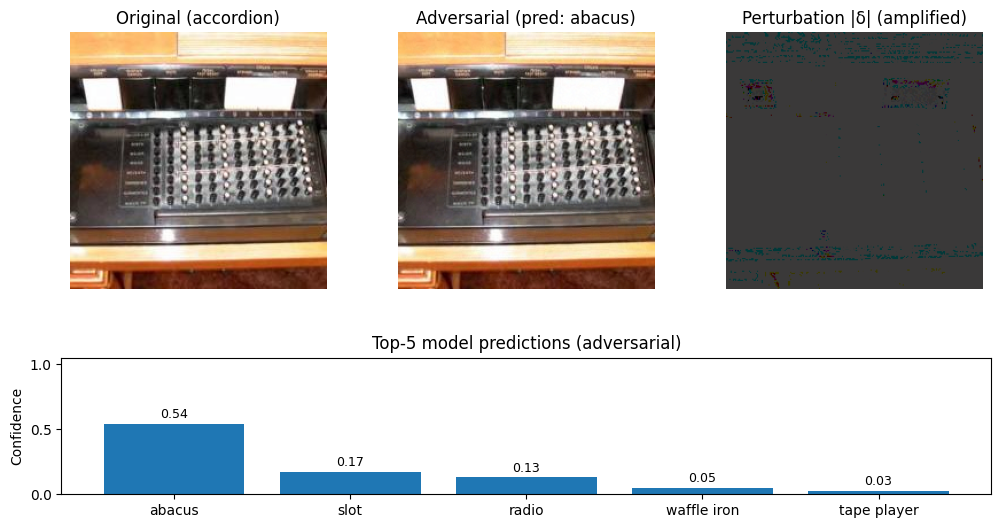

<ipython-input-12-9ad6f79a1943>:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


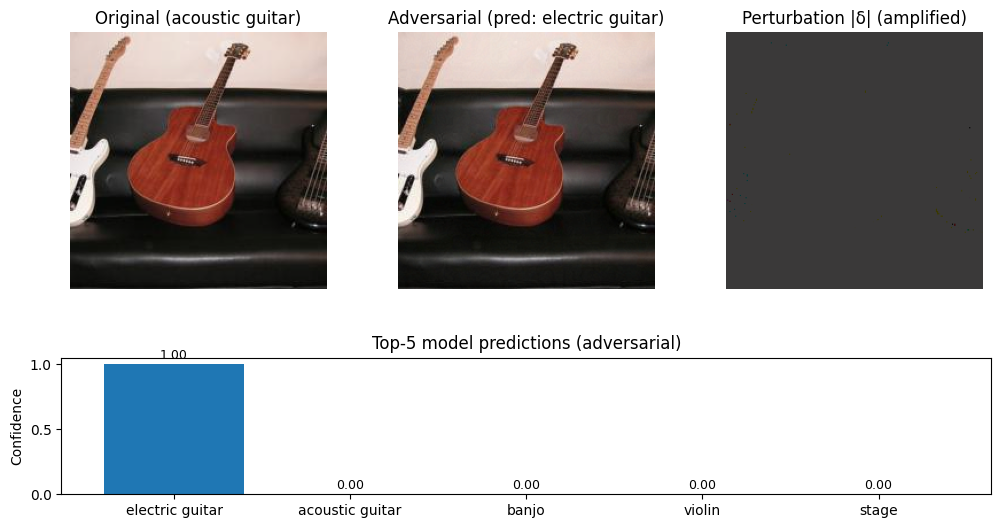

In [12]:
# ─────────────────────────────────────────────────────────────────────────────
#
#
# Implements an FGSM (Fast Gradient Sign Method) adversarial attack against an
# image-classification model, saves adversarial examples, and visualizes results.
# The script assumes that `dataset`, `model`, `device`, `mean_norms`,
# `std_norms`, and the mapping `imagefolder_to_imagenet` have been defined
# earlier in your notebook / program.
# ─────────────────────────────────────────────────────────────────────────────

# Imports & helper functions
# ---------------------------------------------------------------------------

import os
import time
import json
import urllib.request
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
from torch.nn.functional import softmax
from torchvision.utils import save_image
from torch.nn.functional import softmax


def fgsm_attack(
    x: torch.Tensor,
    y: torch.Tensor,
    model: torch.nn.Module,
    criterion: torch.nn.Module,
    eps: float = 0.02,
) -> torch.Tensor:
    """
    Generate an FGSM adversarial example.

    Parameters
    ----------
    x : torch.Tensor
        The original input image tensor of shape (1, C, H, W).
    y : torch.Tensor
        The ground-truth label tensor of shape (1,).
    model : torch.nn.Module
        The neural-network model to attack. It must be in evaluation mode.
    criterion : torch.nn.Module
        Loss function used to compute gradients (e.g., `nn.CrossEntropyLoss()`).
    eps : float, optional
        Infinity-norm (L∞) perturbation budget. Default is 0.02.

    Returns
    -------
    torch.Tensor
        The adversarial image tensor with the same shape as `x`.
    """
    # Track gradients w.r.t. input
    x_adv = x.clone().detach().requires_grad_(True)

    # Forward pass + loss
    loss = criterion(model(x_adv), y)

    # Back-propagate to obtain ∂loss/∂x
    model.zero_grad()
    loss.backward()

    # FGSM perturbation: move each pixel along sign of gradient
    x_adv = x_adv + eps * x_adv.grad.data.sign()

    # Clamp the adversarial image to the ε-ball around x and valid range [0,1]
    return torch.max(torch.min(x_adv, x + eps), x - eps).detach()


# Parameters & setup
# ---------------------------------------------------------------------------

epsilon = 0.02                     # L∞ budget for FGSM
adv_root = "./Adversarial_TestSet1"  # Where adversarial images will be saved
criterion = torch.nn.CrossEntropyLoss()

# Create one output directory per ImageFolder class
for cls in dataset.classes:
    os.makedirs(os.path.join(adv_root, cls), exist_ok=True)

# Metrics we will collect
total = 0
top1_corr = 0
top5_corr = 0
max_perturb = 0.0
vis_examples = []                  # Will hold (orig, adv, noise, label) tuples


# FGSM loop with timing
# ---------------------------------------------------------------------------

start_time = time.time()

for idx in tqdm(range(len(dataset)), desc="FGSM Attack & Save"):

    # Load sample + label, move to device
    x, folder_label = dataset[idx]
    x = x.unsqueeze(0).to(device)                                   # (1,C,H,W)
    y = torch.tensor([imagefolder_to_imagenet[folder_label]],
                     device=device)                                 # (1,)

    # Create adversarial example
    x_adv = fgsm_attack(x, y, model, criterion, epsilon)

    # Update statistics
    max_perturb = max(max_perturb, (x_adv - x).abs().max().item())
    with torch.no_grad():
        adv_out = model(x_adv)
        _, adv_top5 = adv_out.topk(5, dim=1)

    top1_corr += (adv_top5[:, 0] == y).item()                       # top-1 acc
    top5_corr += adv_top5.eq(y.unsqueeze(1)).any(dim=1).item()      # top-5 acc
    total += 1

    # Save adversarial image to disk
    fn = os.path.basename(dataset.samples[idx][0])
    save_image(x_adv.squeeze(0).cpu(),
               os.path.join(adv_root, dataset.classes[folder_label], fn))

    # Store up to 5 visual examples where the adversary fools the model
    if len(vis_examples) < 5 and adv_top5[0, 0] != y:
        noise = (x_adv.squeeze(0) - x.squeeze(0)).cpu()
        vis_examples.append(
            (x.squeeze(0).cpu(), x_adv.squeeze(0).cpu(), noise, y.item())
        )

total_attack_time = time.time() - start_time
avg_time_per_img = total_attack_time / total

# Print summary metrics
print(f"Total attack time:      {total_attack_time:.2f} s")
print(f"Average time / image:   {avg_time_per_img:.4f} s")
print(f"Max L∞ perturbation:    {max_perturb:.4f}  (≤ {epsilon})")
print(f"Adversarial Top-1 Acc.: {100 * top1_corr / total:.2f}%")
print(f"Adversarial Top-5 Acc.: {100 * top5_corr / total:.2f}%")


# Load ImageNet class names (with auto-download fallback)
# ---------------------------------------------------------------------------
try:
    from torchvision.models import ResNet34_Weights  # PyTorch ≥ 2.0
    imagenet_class_names = ResNet34_Weights.IMAGENET1K_V1.meta["categories"]
except Exception:
    # Fallback: download class list text file if needed
    labels_txt = "imagenet_classes.txt"
    if not os.path.isfile(labels_txt):
        urllib.request.urlretrieve(
            "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt",
            labels_txt
        )
    with open(labels_txt) as f:
        imagenet_class_names = [line.strip() for line in f]


# Utility: image de-normalization for visualization
# ---------------------------------------------------------------------------
def denormalize(t: torch.Tensor) -> np.ndarray:
    """
    Undo dataset normalization and convert to H×W×C NumPy array in [0, 1].

    Parameters
    ----------
    t : torch.Tensor
        Tensor of shape (C, H, W) with normalized pixel values.

    Returns
    -------
    np.ndarray
        De-normalized image array with shape (H, W, C).
    """
    img = t.numpy().transpose(1, 2, 0)                # CHW → HWC
    return np.clip(img * std_norms + mean_norms, 0, 1)


# Visualization: plot original, adversarial, perturbation, and top-5 probs
# ---------------------------------------------------------------------------
for i, (orig, adv, noise, true_lbl) in enumerate(vis_examples):
    # 6-a) Get top-5 softmax probabilities for adversarial image
    with torch.no_grad():
        probs = softmax(model(adv.unsqueeze(0).to(device)), dim=1)
    top5_p, top5_c = torch.topk(probs, 5, dim=1)
    top5_p = top5_p.squeeze(0).cpu().numpy()          # (5,)
    top5_c = top5_c.squeeze(0).cpu().numpy()          # (5,)
    top5_names = [imagenet_class_names[c] for c in top5_c]

    # Configure figure with 2×3 GridSpec
    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(
        nrows=2,
        ncols=3,
        height_ratios=[3, 1.6],  # Row 0 = images, Row 1 = bar chart
        hspace=0.35,
    )

    # Original image
    ax_o = fig.add_subplot(gs[0, 0])
    ax_o.imshow(denormalize(orig))
    ax_o.set_title(f"Original ({imagenet_class_names[true_lbl]})")
    ax_o.axis("off")

    # Adversarial image
    ax_a = fig.add_subplot(gs[0, 1])
    ax_a.imshow(denormalize(adv))
    pred_name = imagenet_class_names[top5_c[0]]
    ax_a.set_title(f"Adversarial (pred: {pred_name})")
    ax_a.axis("off")

    # Perturbation heat-map (scaled for visibility)
    ax_n = fig.add_subplot(gs[0, 2])
    noise_img = np.abs(denormalize(adv) - denormalize(orig)) / epsilon
    noise_img = np.clip(noise_img, 0, 1)
    ax_n.imshow(noise_img)
    ax_n.set_title("Perturbation |δ| (amplified)")
    ax_n.axis("off")

    # Bar chart of top-5 probabilities
    ax_b = fig.add_subplot(gs[1, :])
    bars = ax_b.bar(range(5), top5_p, tick_label=top5_names)
    ax_b.set_ylim(0, 1.05)
    ax_b.set_ylabel("Confidence")
    ax_b.set_title("Top-5 model predictions (adversarial)")

    # Add numeric labels above each bar
    for rect, p in zip(bars, top5_p):
        ax_b.text(rect.get_x() + rect.get_width() / 2, p + 0.02,
                  f"{p:.2f}", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()

[PGD    ]  Top-1 / Top-5 =   0.00% /  11.00%   Total:  24.67s   Avg/img: 0.0493s
[MI-FGSM]  Top-1 / Top-5 =   0.20% /  10.20%   Total:  25.28s   Avg/img: 0.0506s

★ Using **PGD** to generate Adversarial_Test_Set_2


✅ Saved 500 adversarial images to './Adversarial_TestSet2'.
Max ‖δ‖∞ across set: 0.02000  (≤ ε = 0.02)


<ipython-input-14-6910fecf5fc9>:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


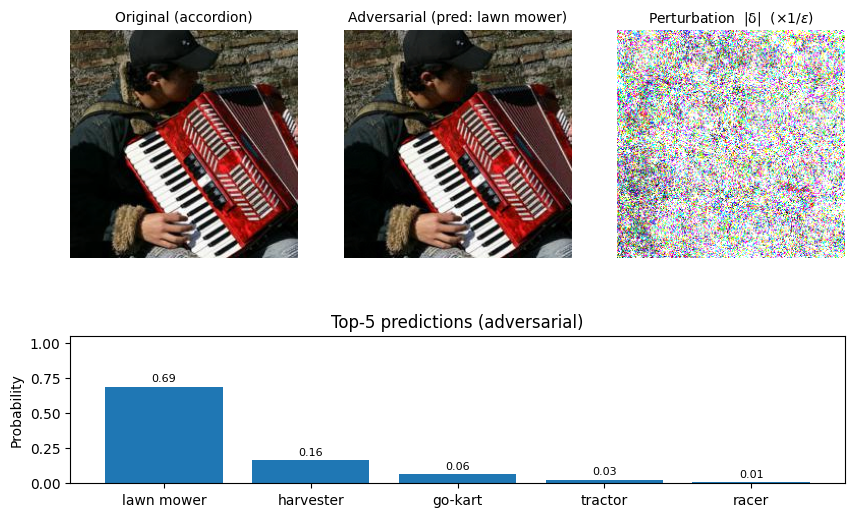

<ipython-input-14-6910fecf5fc9>:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


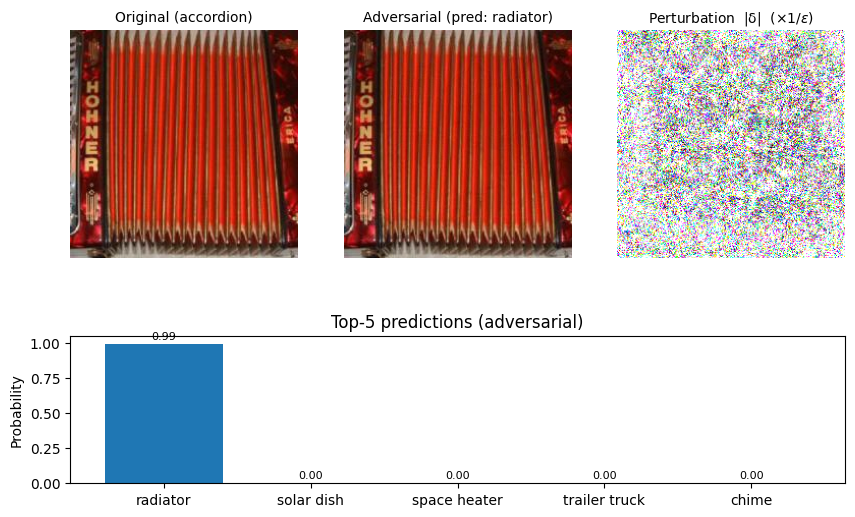

<ipython-input-14-6910fecf5fc9>:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


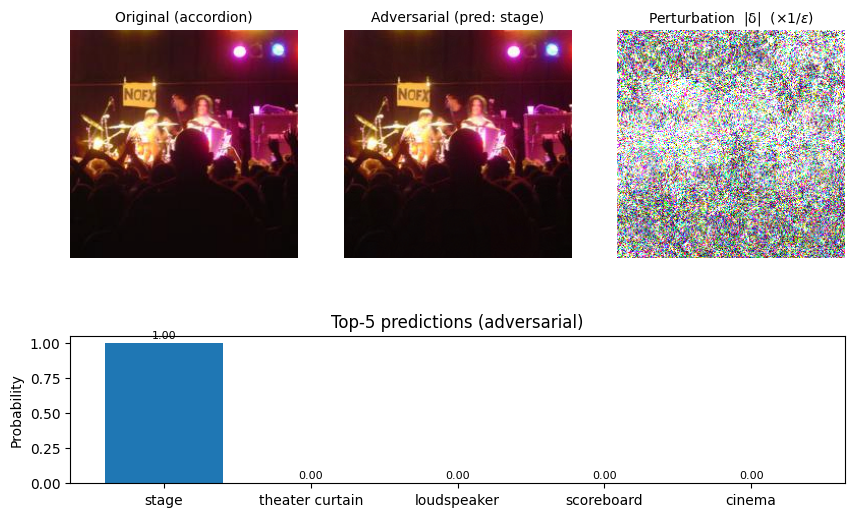

<ipython-input-14-6910fecf5fc9>:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


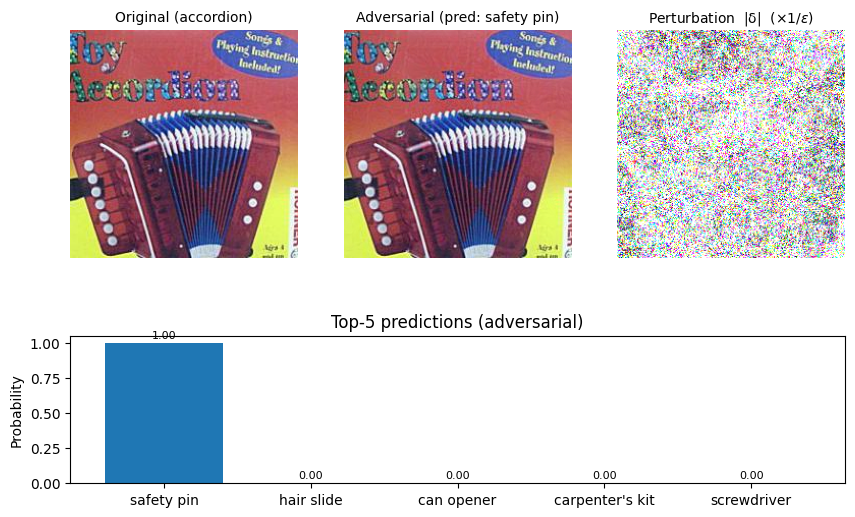

<ipython-input-14-6910fecf5fc9>:175: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


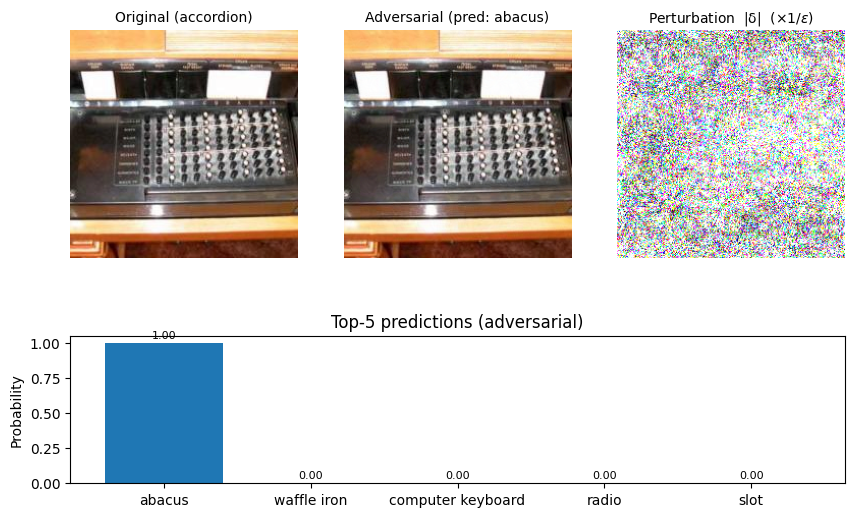

In [14]:
# ─────────────────────────────────────────────────────────────────────────────
# adversarial_testset2.py
#
# Generate and verify “Adversarial Test Set 2” for a fixed ε-budget (0.02).
# The script
#   1.  Loads a zipped image folder and its JSON label mapping.
#   2.  Benchmarks two iterative attacks (PGD and MI-FGSM) on a pre-trained
#       ResNet-34, then chooses the stronger one.
#   3.  Saves every adversarial example to `./Adversarial_TestSet2`, preserving
#       folder hierarchy.
#   4.  Collects up to `VIS_LIMIT` sample triplets for qualitative plots:
#       original • adversarial • perturbation + a Top-5 bar chart.
#
# ─────────────────────────────────────────────────────────────────────────────
from __future__ import annotations

# 0) Imports
# ──────────
import os
import time
import json
import zipfile
from typing import Dict, List, Tuple

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

# Configuration constants
# ---------------------------------------------------------------------------
VIS_LIMIT: int = 5  # How many samples to visualise at the end
EPS: float = 0.02   # L-∞ perturbation budget for all attacks

# Paths
ZIP_PATH: str = "./TestDataSet.zip"
ROOT: str = "./TestDataSet"
ADV_ROOT: str = "./Adversarial_TestSet2"


# 1) Dataset & model set-up
# ────────────────────────────────────────────────────────────────────────────
if not os.path.isdir(ROOT):
    # First-run convenience: unzip dataset in-place
    with zipfile.ZipFile(ZIP_PATH) as zf:
        zf.extractall(".")

# Normalisation statistics (ImageNet)
mean_norms: List[float] = [0.485, 0.456, 0.406]
std_norms: List[float] = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_norms, std_norms),
])

dataset = datasets.ImageFolder(ROOT, transform)
loader: DataLoader = DataLoader(dataset, batch_size=32, shuffle=False)

# Map ImageFolder class-idx → ImageNet class-idx (read from JSON)
with open(os.path.join(ROOT, "labels_list.json")) as f:
    _label_list: Dict[str, str] = json.load(f)

idx2imgnet: Dict[int, int] = {
    v: int(_label_list[v].split(":", 1)[0])
    for v in dataset.class_to_idx.values()
}

# Device / model
device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet34(
    weights=models.ResNet34_Weights.IMAGENET1K_V1
).to(device).eval()

imagenet_class_names: List[str] = \
    models.ResNet34_Weights.IMAGENET1K_V1.meta["categories"]


# 2) Attack definitions
# ────────────────────────────────────────────────────────────────────────────
def pgd(
    x: torch.Tensor,
    y: torch.Tensor,
    eps: float,
    alpha: float,
    steps: int,
    rand_init: bool = True,
) -> torch.Tensor:
    """
    Projected Gradient Descent (ℓ∞) attack.

    Parameters
    ----------
    x : tensor
        Clean inputs in [0, 1] after normalisation.
    y : tensor
        Ground-truth labels (ImageNet indices).
    eps : float
        Perturbation budget (L-∞ norm).
    alpha : float
        Step size.
    steps : int
        Number of iterations.
    rand_init : bool, default True
        If True, start from a random point within the ε-ball.

    Returns
    -------
    torch.Tensor
        Adversarial examples with the same shape as `x`.
    """
    x_adv = x + torch.empty_like(x).uniform_(-eps, eps) if rand_init else x.clone()
    for _ in range(steps):
        x_adv.requires_grad_(True)
        model.zero_grad(set_to_none=True)
        F.cross_entropy(model(x_adv), y).backward()
        x_adv = x_adv + alpha * x_adv.grad.sign()
        x_adv = torch.clamp(x_adv, x - eps, x + eps).detach()
    return x_adv


def mi_fgsm(
    x: torch.Tensor,
    y: torch.Tensor,
    eps: float,
    alpha: float,
    steps: int,
    mu: float = 1.0,
) -> torch.Tensor:
    """
    Momentum Iterative FGSM (MI-FGSM) as described in
    “Boosting Adversarial Attacks with Momentum” (Dong et al., 2018).

    Notes
    -----
    • Gradients are normalised by their mean absolute value to stabilise scale.
    • `mu` is the decay factor for the momentum term.
    """
    g = torch.zeros_like(x)  # Accumulated gradient (momentum)
    x_adv = x.clone()

    for _ in range(steps):
        x_adv.requires_grad_(True)
        model.zero_grad(set_to_none=True)
        F.cross_entropy(model(x_adv), y).backward()

        # Normalised gradient (channel-wise)
        grad = x_adv.grad / (x_adv.grad.abs().mean((1, 2, 3), keepdim=True) + 1e-8)
        g = mu * g + grad
        x_adv = torch.clamp(x_adv + alpha * g.sign(), x - eps, x + eps).detach()

    return x_adv


# Attack registry
attacks = {"PGD": pgd, "MI-FGSM": mi_fgsm}
params = {"eps": EPS, "alpha": 0.005, "steps": 10}


# Benchmark both attacks & choose the strongest
# ────────────────────────────────────────────────────────────────────────────
def benchmark(fn) -> Tuple[float, float, float, float]:
    """
    Evaluate one attack across the entire dataset.

    Returns
    -------
    (top1_acc, top5_acc, total_time_s, avg_time_per_img_s)
    """
    n = top1 = top5 = 0
    start = time.time()

    for imgs, labs in loader:
        imgs = imgs.to(device)
        labs = torch.tensor([idx2imgnet[int(l)] for l in labs], device=device)

        advs = fn(imgs.clone(), labs, **params)

        with torch.no_grad():
            _, preds_top5 = model(advs).topk(5, 1)

        top1 += (preds_top5[:, 0] == labs).sum().item()
        top5 += (preds_top5 == labs.unsqueeze(1)).any(1).sum().item()
        n += imgs.size(0)

    total_time = time.time() - start
    return 100 * top1 / n, 100 * top5 / n, total_time, total_time / n


scores: Dict[str, Tuple[float, float, float, float]] = {}
for name, fn in attacks.items():
    t1, t5, tot, avg = benchmark(fn)
    scores[name] = (t1, t5, tot, avg)
    print(f"[{name:<7}]  Top-1 / Top-5 = {t1:6.2f}% / {t5:6.2f}%   "
          f"Total: {tot:6.2f}s   Avg/img: {avg:0.4f}s")

# Choose attack with the **lower** top-1 accuracy (i.e., stronger)
best_name: str = min(scores, key=lambda k: scores[k][0])
best_fn = attacks[best_name]
print(f"\n★ Using **{best_name}** to generate Adversarial_TestSet2\n")


# Generate & save adversarial set (+ gather VIS_LIMIT samples)
# ─────────────────────────────────────────────────────────────────
os.makedirs(ADV_ROOT, exist_ok=True)

# Inverse normalisation for uint8 saving
inv_norm = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean_norms, std_norms)],
    std=[1 / s for s in std_norms],
)

sample_vis: List[
    Tuple[np.ndarray, ...]
] = []  # (orig, adv, pert, true_lbl, pred_lbl, top5_names, top5_probs)
global_max = 0.0
global_idx = 0

for imgs, labs in loader:
    imgs = imgs.to(device)
    labs = torch.tensor([idx2imgnet[int(l)] for l in labs], device=device)
    advs = best_fn(imgs, labs, **params).cpu()

    # Probabilities for the whole batch (one forward pass)
    with torch.no_grad():
        probs = F.softmax(model(advs.to(device)), dim=1).cpu()

    for b in range(advs.size(0)):
        # Maintain original relative path → save adversarial counterpart
        orig_path = dataset.samples[global_idx][0]
        rel_path = os.path.relpath(orig_path, ROOT)
        save_path = os.path.join(ADV_ROOT, rel_path)
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        # L-∞ size for bookkeeping
        delta = (advs[b] - imgs[b].cpu()).abs()
        global_max = max(global_max, delta.max().item())

        # Save uint8 image
        adv_uint8 = (
            inv_norm(advs[b]).clamp(0, 1).permute(1, 2, 0).numpy() * 255
        ).astype(np.uint8)
        Image.fromarray(adv_uint8).save(save_path)

        # Collect visualisation samples
        if len(sample_vis) < VIS_LIMIT:
            orig_uint8 = (
                inv_norm(imgs[b].cpu()).clamp(0, 1).permute(1, 2, 0).numpy() * 255
            ).astype(np.uint8)

            pert_uint8 = (
                np.clip(delta.numpy() / params["eps"], 0, 1).transpose(1, 2, 0) * 255
            ).astype(np.uint8)

            top5_prob, top5_cls = probs[b].topk(5)
            top5_prob = top5_prob.numpy()
            top5_cls = top5_cls.numpy()
            top5_names = [imagenet_class_names[c] for c in top5_cls]

            true_lbl = imagenet_class_names[labs[b].item()]
            pred_lbl = top5_names[0]

            sample_vis.append(
                (
                    orig_uint8,
                    adv_uint8,
                    pert_uint8,
                    true_lbl,
                    pred_lbl,
                    top5_names,
                    top5_prob,
                )
            )
        global_idx += 1

print(f"\nSaved {global_idx} adversarial images → '{ADV_ROOT}'.")
print(f"Max ‖δ‖∞ across set: {global_max:.5f}  (≤ ε = {params['eps']})")


# Visualise a few examples (original • adversarial • perturbation)
# ────────────────────────────────────────────────────────────────────
for (
    orig,
    adv,
    pert,
    true_lbl,
    pred_lbl,
    top5_names,
    top5_prob,
) in sample_vis:

    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(2, 3, height_ratios=[3, 1.8], hspace=0.35)

    # Row-1: images -----------------------------------------------------------
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.imshow(orig)
    ax0.axis("off")
    ax0.set_title(f"Original ({true_lbl})", fontsize=10)

    ax1 = fig.add_subplot(gs[0, 1])
    ax1.imshow(adv)
    ax1.axis("off")
    ax1.set_title(f"Adversarial (pred: {pred_lbl})", fontsize=10)

    ax2 = fig.add_subplot(gs[0, 2])
    ax2.imshow(pert)
    ax2.axis("off")
    ax2.set_title(r"Perturbation |δ| (×$1/ε$)", fontsize=10)

    # Row-2: bar chart --------------------------------------------------------
    axb = fig.add_subplot(gs[1, :])
    bars = axb.bar(range(5), top5_prob, tick_label=top5_names)
    axb.set_ylim(0, 1.05)
    axb.set_ylabel("Probability")
    axb.set_title("Top-5 predictions (adversarial)")

    # Annotate each bar with its probability
    for rect, p in zip(bars, top5_prob):
        axb.text(
            rect.get_x() + rect.get_width() / 2,
            p + 0.02,
            f"{p:.2f}",
            ha="center",
            va="bottom",
            fontsize=8,
        )

    plt.tight_layout()
    plt.show()

Mask-Patch PGD: 100%|██████████| 500/500 [02:18<00:00,  3.62it/s]


Max patch L∞: 2.1179  (≤ 0.3)
Patch-PGD set → Top-1 19.60%  |  Top-5 44.00%
Total attack time: 138.21 s
Average time / image: 0.2764 s


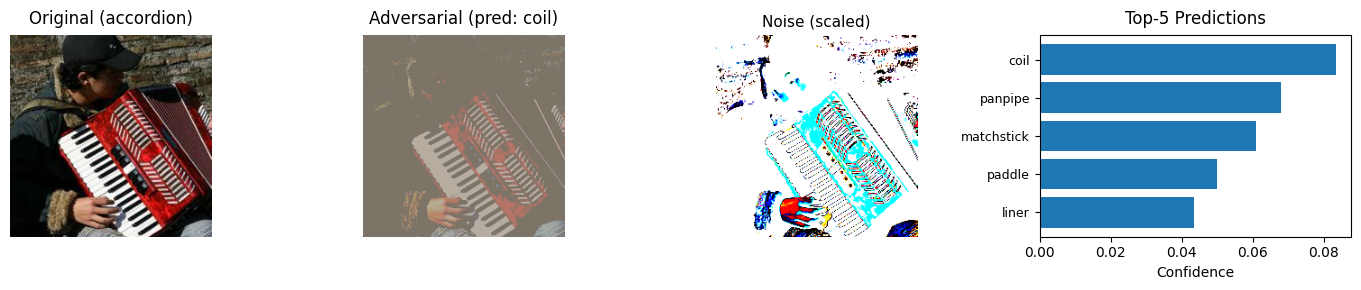

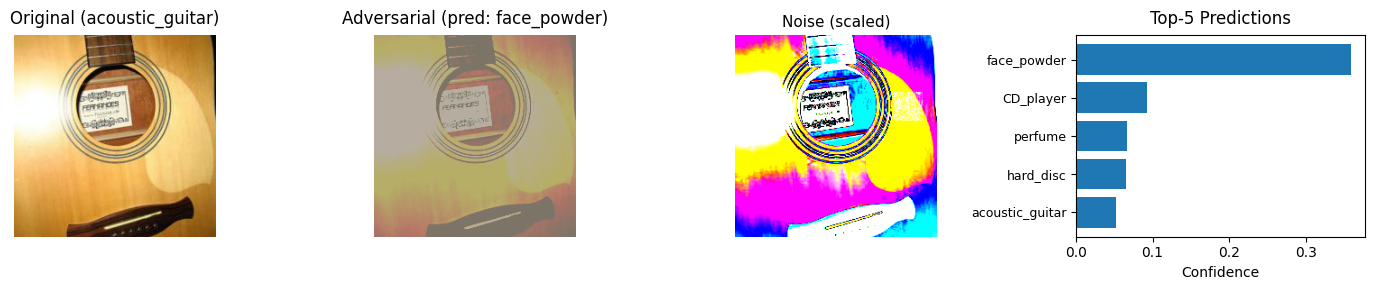

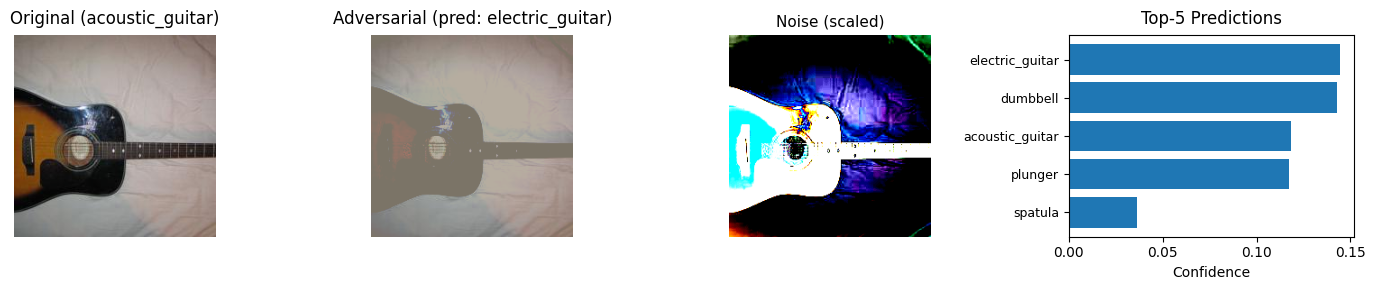

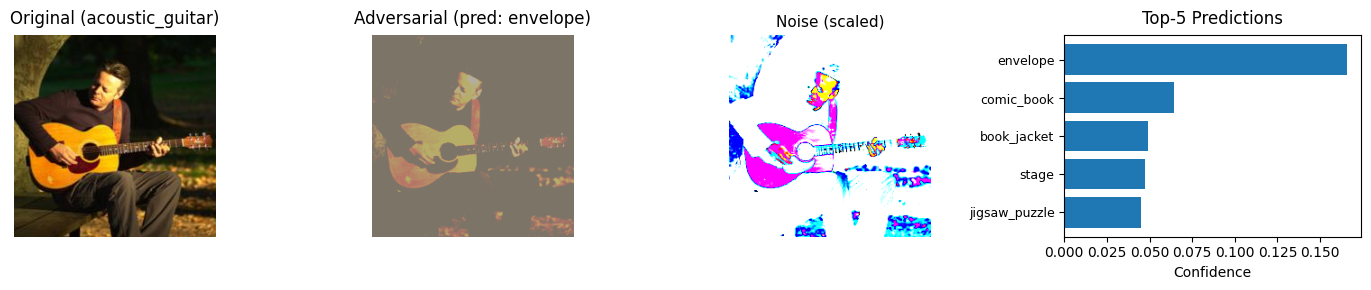

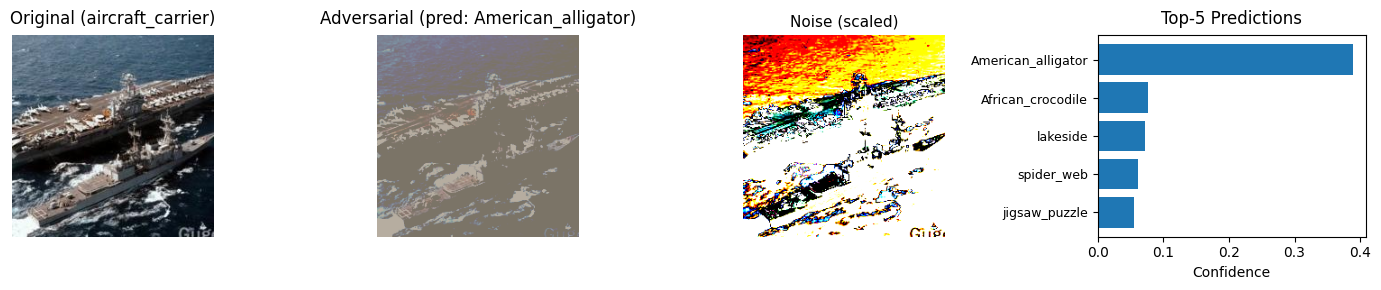

In [13]:
# ─────────────────────────────────────────────────────────────────────────────
# mask_patch_pgd_attack.py
#
# Implements a *mask-based* Patch-PGD adversarial attack:
#   • A square mask of size `patch_size × patch_size` is placed at a random
#     location on every input. Only the pixels under that mask are perturbed.
#   • Perturbations are constrained inside an ℓ∞ ball of radius `epsilon_patch`.
#   • A fixed number of iterations (`steps_patch`) with step size `alpha_patch`
#     are performed (a variant of projected gradient descent).
#
# The script:
#   1.  Creates an adversarial test set on disk (`./Adversarial_TestSet3`),
#       preserving the original ImageFolder directory tree.
#   2.  Logs aggregated Top-1/Top-5 accuracies for the attacked model.
#   3.  Visualises up to five “interesting” examples where the attack flips
#       the model’s prediction, showing:
#           – Original image
#           – Adversarial image
#           – Normalised perturbation heat-map
#           – Horizontal bar chart of adversarial Top-5 probabilities
#
# ─────────────────────────────────────────────────────────────────────────────
from __future__ import annotations

# 0) Imports
# ──────────
import json
import os
import pathlib
import time
import urllib.request
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from torchvision.utils import save_image

# 0-a) Attack hyper-parameters & output directory
# ---------------------------------------------------------------------------
epsilon_patch: float = 0.30         # ℓ∞ radius for *mask* pixels only
steps_patch: int = 20               # Number of PGD iterations
alpha_patch: float = epsilon_patch / steps_patch
patch_size: int = 32                # Square side-length (pixels)

adv4_root: str = "./Adversarial_TestSet3"
criterion = torch.nn.CrossEntropyLoss()

for _cls in dataset.classes:        # mkdir ./Adversarial_TestSet3/…/class
    os.makedirs(os.path.join(adv4_root, _cls), exist_ok=True)


# Patch-PGD helper
# ────────────────────────────────────────────────────────────────────────────
def patch_pgd_attack_masked(
    model: torch.nn.Module,
    x: torch.Tensor,
    y: torch.Tensor,
    eps: float = epsilon_patch,
    alpha: float = alpha_patch,
    iters: int = steps_patch,
    patch_size: int = 32,
) -> torch.Tensor:
    """
    Patch-based PGD (ℓ∞) adversarial attack.

    Only pixels within a randomly placed square mask are modified.

    Parameters
    ----------
    model : nn.Module
        Victim model in evaluation mode.
    x : Tensor
        Mini-batch of inputs, shape (B, C, H, W) *pre-normalisation applied*.
    y : Tensor
        Corresponding ground-truth labels (ImageNet indices).
    eps : float, default `epsilon_patch`
        ℓ∞ perturbation budget (applied **inside** the mask).
    alpha : float, default `alpha_patch`
        Step size per PGD iteration.
    iters : int, default `steps_patch`
        Number of PGD iterations.
    patch_size : int, default 32
        Width/height of the square mask in pixels.

    Returns
    -------
    Tensor
        Adversarial examples with the same shape and dtype as `x`.
    """
    # Keep originals for projection step
    x_orig = x.clone().detach().to(device)
    x_adv = x.clone().detach().to(device)
    y = y.to(device)

    # Build a binary mask with one random patch per image
    B, _, H, W = x_adv.shape
    mask = torch.zeros_like(x_adv)
    top = np.random.randint(0, H - patch_size)
    left = np.random.randint(0, W - patch_size)
    mask[:, :, top : top + patch_size, left : left + patch_size] = 1

    # Optional random start inside ε-ball (masked)
    x_adv = torch.clamp(x_adv + mask * torch.empty_like(x_adv).uniform_(-eps, eps), 0, 1)

    # PGD iterations
    for _ in range(iters):
        x_adv.requires_grad_(True)
        loss = criterion(model(x_adv), y)
        loss.backward()

        # Gradient ascent under the mask, then project & clamp
        grad = x_adv.grad.detach().sign()
        x_adv = x_adv.detach() + mask * alpha * grad
        x_adv = torch.max(torch.min(x_adv, x_orig + eps), x_orig - eps)
        x_adv = torch.clamp(x_adv, 0, 1)

    return x_adv.detach()


# Helpers for visualisation / label lookup
# ────────────────────────────────────────────────────────────────────────────
def denorm(t: torch.Tensor) -> np.ndarray:
    """Inverse normalisation → NumPy array in [0, 1] (H, W, C)."""
    img = t.numpy().transpose(1, 2, 0)
    return np.clip(img * std_norms + mean_norms, 0, 1)


def _load_imagenet_names() -> List[str]:
    """
    Return a list of 1 000 human-readable ImageNet labels.

    Tries:
    1.  `model.meta["categories"]` (torchvision ≥ 0.15).
    2.  Local `imagenet_class_index.json` (downloaded once if absent).

    Falls back to class_xxx if an index is out of range.
    """
    try:
        return model.meta["categories"]  # type: ignore[attr-defined]
    except Exception:
        ...

    cache = pathlib.Path("./imagenet_class_index.json")
    if not cache.exists():
        url = ("https://s3.amazonaws.com/deep-learning-models/"
               "image-models/imagenet_class_index.json")
        urllib.request.urlretrieve(url, cache)

    with cache.open() as f:
        class_idx = json.load(f)          # {"0": ["n01440764", "tench"], …}
    return [class_idx[str(i)][1] for i in range(len(class_idx))]


imagenet_names: List[str] = _load_imagenet_names()


def id2name(idx: int) -> str:
    """Safe index → name (or 'class_<idx>' if OOB)."""
    return imagenet_names[idx] if 0 <= idx < len(imagenet_names) else f"class_{idx}"


# 3) Attack loop
# ────────────────────────────────────────────────────────────────────────────
softmax = torch.nn.Softmax(dim=1)

total = top1_corr = top5_corr = 0
max_perturb = 0.0
visuals_patch: List[
    Tuple[torch.Tensor, ...]
] = []  # (orig, adv, heat, orig5, adv5, true_lbl)

attack_start = time.perf_counter()

for idx in tqdm(range(len(dataset)), desc="Mask-Patch PGD"):
    # 3-a) Load image + label to device
    x, folder_lbl = dataset[idx]
    x = x.unsqueeze(0).to(device)                                         # (1,C,H,W)
    y = torch.tensor([imagefolder_to_imagenet[folder_lbl]], device=device)

    # Original predictions
    with torch.no_grad():
        logits_orig = model(x)
        _, top5_orig = logits_orig.topk(5, dim=1)                         # (1,5)

    # 3-b) Generate adversarial image
    x_adv = patch_pgd_attack_masked(model, x, y)

    # Adversarial predictions
    with torch.no_grad():
        logits_adv = model(x_adv)
        _, top5_adv = logits_adv.topk(5, dim=1)

    # 3-c) Update metrics
    top1_corr += (top5_adv[:, 0] == y).item()
    top5_corr += top5_adv.eq(y.unsqueeze(1)).any(dim=1).item()
    total += 1
    max_perturb = max(max_perturb, (x_adv - x).abs().max().item())

    # 3-d) Save adversarial image on disk
    fname = os.path.basename(dataset.samples[idx][0])
    save_path = os.path.join(adv4_root, dataset.classes[folder_lbl], fname)
    save_image(x_adv.squeeze(0).cpu(), save_path)

    # 3-e) Record up to 5 interesting visualisations (orig correct, adv wrong)
    if (
        len(visuals_patch) < 5
        and (top5_orig[:, 0] == y)
        and (top5_adv[:, 0] != y)
    ):
        heat = (
            (x_adv - x).abs()
            .squeeze(0)
            .cpu()
            .clamp(0, epsilon_patch)
            / epsilon_patch
        )
        visuals_patch.append(
            (
                x.squeeze(0).cpu(),
                x_adv.squeeze(0).cpu(),
                heat,
                top5_orig.squeeze(0).cpu().tolist(),
                top5_adv.squeeze(0).cpu().tolist(),
                y.item(),
            )
        )

attack_time = time.perf_counter() - attack_start


# 4) Summary statistics
# ────────────────────────────────────────────────────────────────────────────
print(f"Max patch L∞:      {max_perturb:.4f}  (≤ {epsilon_patch})")
print(f"Patch-PGD accuracy: Top-1 {100 * top1_corr / total:.2f}%  |  "
      f"Top-5 {100 * top5_corr / total:.2f}%")
print(f"Total attack time:  {attack_time:.2f} s")
print(f"Average time/img:   {attack_time / total:.4f} s")


# 5) Qualitative visualisation (4-panel)
# ────────────────────────────────────────────────────────────────────────────
for orig, adv, heat, orig5, adv5, lbl in visuals_patch:
    true_name = id2name(lbl)
    adv_top1_name = id2name(adv5[0])

    # Softmax probs for bar chart
    with torch.no_grad():
        probs_adv = softmax(model(adv.unsqueeze(0).to(device))).cpu().squeeze(0)
    adv5_names = [id2name(int(k)) for k in adv5]
    adv5_probs = probs_adv[adv5].numpy()

    # Figure layout: original | adversarial | heat-map | bar chart
    fig, axes = plt.subplots(
        1,
        4,
        figsize=(14, 3),
        gridspec_kw=dict(width_ratios=[1, 1, 1, 1.2]),
    )

    # (a) Original
    axes[0].imshow(denorm(orig))
    axes[0].axis("off")
    axes[0].set_title(f"Original ({true_name})", fontsize=12, pad=8)

    # (b) Adversarial
    axes[1].imshow(denorm(adv))
    axes[1].axis("off")
    axes[1].set_title(f"Adversarial (pred: {adv_top1_name})", fontsize=12, pad=8)

    # (c) Heat-map
    axes[2].imshow(heat.permute(1, 2, 0), cmap="hot")
    axes[2].axis("off")
    axes[2].set_title("Noise (scaled)", fontsize=11)

    # (d) Horizontal bar chart
    y_pos = np.arange(5)[::-1]
    axes[3].barh(y_pos, adv5_probs[::-1])
    axes[3].set_yticks(y_pos)
    axes[3].set_yticklabels(adv5_names[::-1], fontsize=9)
    axes[3].invert_yaxis()
    axes[3].set_xlabel("Confidence")
    axes[3].set_title("Top-5 Predictions", pad=8)

    plt.tight_layout()
    plt.show()

In [10]:
# ─────────────────────────────────────────────────────────────────────────────
# evaluate_densenet121.py
#
# Benchmarks DenseNet-121 on:
#   • The original ImageFolder test set            (./TestDataSet)
#   • All sibling folders whose names start with   Adversarial_TestSet*
# ─────────────────────────────────────────────────────────────────────────────
from __future__ import annotations

# 0) Imports
# ──────────
import json
import os
from typing import Dict, Tuple

import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

# Device & transform
# ---------------------------------------------------------------------------
device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean_norms = [0.485, 0.456, 0.406]   # ImageNet statistics
std_norms = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_norms, std_norms),
])

# ---------------------------------------------------------------------------
# Load ImageNet label mapping for this dataset
# ---------------------------------------------------------------------------
with open("./TestDataSet/labels_list.json") as f:
    label_list: Dict[str, str] = json.load(f)
    # Example entry: "0": "65:n01615121|karo|..." → we need the '65'

# ---------------------------------------------------------------------------
# Model: DenseNet-121 (ImageNet-1k pretrained weights)
# ---------------------------------------------------------------------------
densenet121 = models.densenet121(
    weights=models.DenseNet121_Weights.IMAGENET1K_V1
).to(device).eval()


# ---------------------------------------------------------------------------
# Helper: compute Top-1 / Top-5 accuracy for a given ImageFolder root
# ---------------------------------------------------------------------------
@torch.no_grad()
def accuracy_for_folder(root: str, batch_size: int = 32) -> Tuple[float, float]:
    """
    Evaluate DenseNet-121 on an ImageFolder directory.

    Parameters
    ----------
    root : str
        Path to the ImageFolder dataset.
    batch_size : int, default 32
        Mini-batch size for the DataLoader.

    Returns
    -------
    (top1, top5) : Tuple[float, float]
        Top-1 and Top-5 accuracies in *percent*.
    """
    ds = datasets.ImageFolder(root, transform=transform)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)

    # Map dataset class-index → canonical ImageNet class-index
    idx2imgnet = {
        v: int(label_list[v].split(":", 1)[0])  # ← bug-fix: use ImageNet idx
        for v in ds.class_to_idx.values()
    }

    top1 = top5 = total = 0
    for x, local_y in dl:
        x = x.to(device)
        y = torch.tensor([idx2imgnet[int(lbl)] for lbl in local_y], device=device)

        logits = densenet121(x)
        _, preds5 = logits.topk(5, dim=1)

        top1 += (preds5[:, 0] == y).sum().item()
        top5 += (preds5 == y.unsqueeze(1)).any(dim=1).sum().item()
        total += x.size(0)

    return 100.0 * top1 / total, 100.0 * top5 / total


# ---------------------------------------------------------------------------
# Assemble list of datasets to evaluate
# ---------------------------------------------------------------------------
datasets_to_eval: Dict[str, str] = {"Original": "./TestDataSet"}

# Add every sibling directory that matches Adversarial_TestSet*
datasets_to_eval.update({
    d: d
    for d in sorted(os.listdir("."))
    if d.startswith("Adversarial_TestSet") and os.path.isdir(d)
})

# ---------------------------------------------------------------------------
# Run evaluation and collect results
# ---------------------------------------------------------------------------
records = []
for name, path in datasets_to_eval.items():
    top1, top5 = accuracy_for_folder(path)
    records.append({
        "Dataset": name,
        "Top-1 (%)": round(top1, 2),
        "Top-5 (%)": round(top5, 2),
    })

df = pd.DataFrame(records).set_index("Dataset").sort_index()


# ---------------------------------------------------------------------------
#Pretty-print results (Jupyter or plain Python)
# ---------------------------------------------------------------------------
try:
    # Jupyter / IPython rich display
    from IPython.display import display  # type: ignore
    display(df)
except ImportError:
    # Fallback CLI output
    print(df.to_string())

Top-1 (%)  Top-5 (%)
Dataset                                   
Adversarial_TestSet1       41.8       67.2
Adversarial_TestSet2       42.2       68.2
Adversarial_TestSet3       44.2       68.4
Original                   74.8       93.6